# CNN Deconvolution

In [1]:
%env CUDA_VISIBLE_DEVICES = ""

env: CUDA_VISIBLE_DEVICES=""


In [2]:
import os 
import tensorflow as tf 
import tensorflow.keras as keras
tf.config.gpu.set_per_process_memory_growth(True)
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

Use a pretrained model like VGG16 and VGG19 trained on ImageNet to do the task.

In [3]:
vgg19 = keras.applications.VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [4]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
# Download an image and read it into a NumPy array, 
def download(url):
    name = os.path.basename(url)
    image_path = tf.keras.utils.get_file(name, origin=url, cache_subdir='images', cache_dir='./')
    img = image.load_img(image_path)
    return image.img_to_array(img)

def urllib_download(url, cache_dir='images/', img_name=''):
    import urllib.request
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)
    img_name = os.path.basename(url) if not img_name else img_name
    image_path = urllib.request.urlretrieve(url, cache_dir + os.path.basename(url))
    img = image.load_img(image_path[0])
    return image.img_to_array(img)

# # deprocess (feature space)
def deprocess(img):
    img = img.copy()
    # normalized tensor: center at 0., std at 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    # clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)
    
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

# Display an image
def show(img, title=None):
    plt.figure(figsize=(8, 8))
    plt.grid(False)
    plt.axis('off')
    if len(img.shape) > 3:
        img = img.squeeze(0)
    title = title if title else img.shape
    plt.title(title)
    plt.imshow(img)


In [6]:
url = 'https://i.pinimg.com/originals/e0/97/58/e097587c01351a08594fc1feef39e51b.jpg'
# img = preprocess(urllib_download(url, img_name='john-wick-2-dog.jpg'))
# show(deprocess(img))

In [7]:
def load_image(path_to_img, img_shape=(224, 224)):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    max_dim = 512
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, 0)
    return img

0.0 1.0


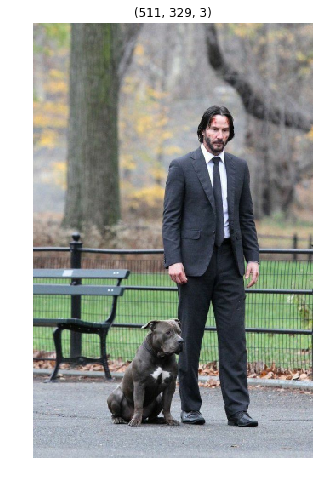

In [8]:
img = load_image('images/john-wick-2-dog.jpg')
print(img.numpy().min(), img.numpy().max())
show(img.numpy())

## Deconvolution

In [9]:
# create a deconvolution model that is reverse the forward pass model.
def deconvnet_model(model, layer_name):
    deconv_layers = []
    for i in range(len(model.layers)):
        if isinstance(model.layers[i], keras.layers.Conv2D):
            weights = model.layers[i].get_weights()[0]
            weights_h, weights_w, inp_filters, out_filters = weights.shape
            deconv_layer = keras.layers.Conv2DTranspose(inp_filters, (weights_h, weights_w),
                                                  input_shape=(model.layers[i].output_shape[1:]),
                                                  strides=model.layers[i].get_config()['strides'],
                                                  padding=model.layers[i].get_config()['padding'],
                                                  activation=model.layers[i].get_config()['activation'],
                                                  kernel_initializer=tf.constant_initializer(weights), 
                                                  bias_initializer=tf.zeros_initializer())
            deconv_layers.append(deconv_layer)
        elif isinstance(model.layers[i], keras.layers.MaxPooling2D):
            deconv_layer = keras.layers.UpSampling2D(model.layers[i].get_config()['pool_size'], interpolation="bilinear")
            deconv_layers.append(deconv_layer)
        
        elif isinstance(model.layers[i], keras.layers.AveragePooling2D):
            deconv_layer = keras.layers.UpSampling2D(model.layers[i].get_config()['pool_size'], interpolation="bilinear")
            deconv_layers.append(deconv_layer)
            
        if model.layers[i].name == layer_name:
            break
    deconv_model = tf.keras.Sequential(deconv_layers[::-1])
    return deconv_model

In [40]:
# visualize the filter activation using deconvolution model.
def visualization_using_deconvolution(orig_model, deconv_model, vis_image, feature_to_visualize):
    
    vis_image = tf.image.resize(vis_image, (224, 224))
    vis_image = tf.cast(vis_image * 255.0, 'uint8').numpy()
    vis_image = tf.keras.applications.vgg19.preprocess_input(vis_image)
    
    vis_image = orig_model(vis_image)
    feature_map = vis_image[:, :, :, feature_to_visualize]

    output = np.zeros_like(vis_image)
    output[:,:,:, feature_to_visualize] = feature_map.numpy()
    return deconv_model(output).numpy()

In [84]:
def post_process(img):
    img -= img.min()
    img *= 1.0 / (img.max() + 1e-8)
    img = (img * 255).astype(np.uint8)
    return img.squeeze() if img.ndim == 4 else img

# display images in row format
def display_in_row(features, figname='', max_images=8, images_per_row=8):
    n_features = features.shape[0]
    n_features = min(n_features, max_images)

    size = features.shape[1]
    n_cols = (n_features // (images_per_row+1)) + 1
    images_per_row = min(n_features, images_per_row)
    
    if features.ndim == 4:
        display_grid = np.zeros((size * n_cols, images_per_row * size, features.shape[-1]), dtype=np.int32) + 255
    else:
        display_grid = np.zeros((size * n_cols, images_per_row * size)) + 255
        
    # plot on grid
    for col in range(n_cols):
        for row in range(images_per_row):
            if col * images_per_row + row < n_features:
                channel_image = features[col * images_per_row + row, ...]
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')  
    plt.tight_layout()
#     plt.savefig(figname, dpi=300)
    plt.show()

In [88]:
vis_layer = 'block4_conv1'
target_output = vgg19.get_layer(vis_layer).output 
vgg19_submodel = tf.keras.Model(vgg19.input, target_output)
vgg19_deconv = deconvnet_model(vgg19, vis_layer)

In [89]:
vis_outputs = []
idx = 15
for idx in range(16):
    vis_output = visualization_using_deconvolution(vgg19_submodel, vgg19_deconv, img, idx)
    vis_outputs.append(post_process(vis_output))
layer_outputs = np.stack(vis_outputs)

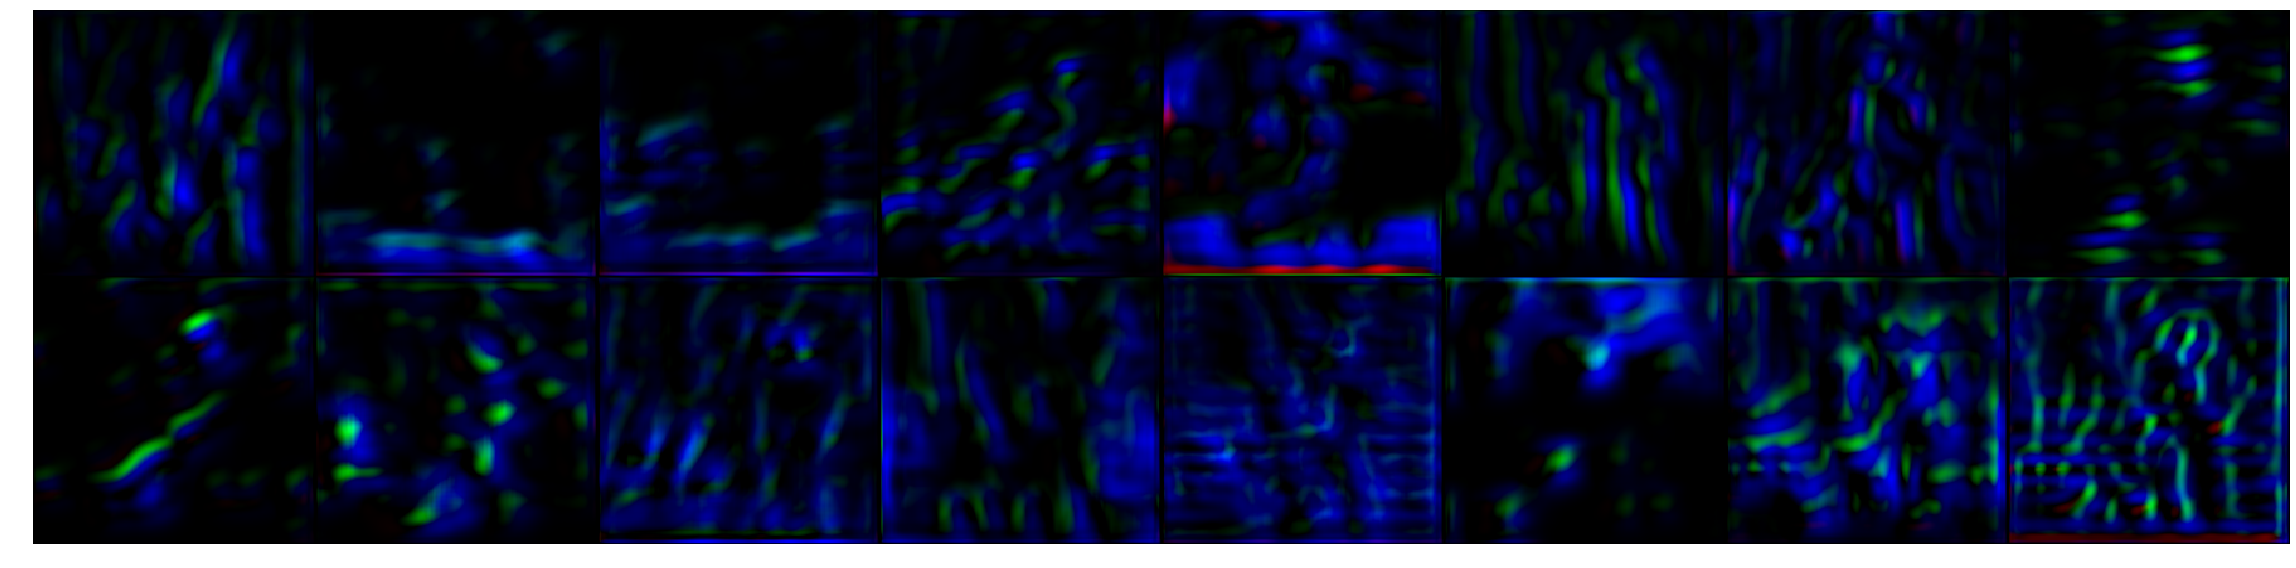

In [90]:
display_in_row(layer_outputs, max_images=16)

In [15]:
layer_outputs.shape

(16, 224, 224, 3)